In [1]:
from collections import deque
from enum import Enum
from graphviz import Digraph
import json
import math
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
class Op(Enum):
    NONE = 0
    ADD = 1
    MUL = 2

    def __str__(self):
        match self:
            case Op.NONE:
                return "none"
            case Op.ADD:
                return "addition"
            case Op.MUL:
                return "multiplication"
            case _:
                raise ValueError("Unknown operation")

    def opstr(self):
        match self:
            case Op.NONE:
                return ""
            case Op.ADD:
                return "+"
            case Op.MUL:
                return "*"
            case _:
                raise ValueError("Unknown operation")


In [3]:
class Value:
    def __init__(self, value, children=set(), operation=Op.NONE, label="", gradient=0.0):
        self.value = value
        self.children = children
        self.operation = operation
        self.label = label
        self.gradient = gradient
        self.backward = lambda: None

    def backpropagation(self):
        self.gradient = 1.0
        queue = [self]
        while len(queue) > 0:
            current = queue[0]
            queue = queue[1:]
            current.backward()
            queue.extend([child for child in current.children])
    
    def __add__(self, other):
        result = Value(
            value=self.value + other.value,
            children={self, other},
            operation=Op.ADD,
        )
        def backward():
            self.gradient = result.gradient
            other.gradient = result.gradient
        result.backward = backward
        return result
        

    def __mul__(self, other):
        result = Value(
            value=self.value * other.value,
            children={self, other},
            operation=Op.MUL,
        )
        def backward():
            self.gradient = other.value * result.gradient
            other.gradient = self.value * result.gradient
        result.backward = backward
        return result
        
    def __str__(self):        
        s = json.dumps({
            "value": self.value,
            "children": [json.loads(str(v)) for v in self.children],
            "operation": str(self.operation),
        }, indent=2)
        return s
    
    def __repr__(self):
        return str(self)
        
    def render_graph(self):
        digraph = Digraph(format="svg", graph_attr={"rankdir": "LR"})
        queue = deque([self])
        while queue:
            current = queue.popleft()
            current_id = str(id(current))
            label = "%s | value: %.4f | gradient: %.4f" % (current.label, current.value, current.gradient)
            digraph.node(name=current_id, label=label, shape="record")
            if current.operation != Op.NONE:
                op_id = current_id + str(current.operation)
                digraph.node(
                    name=op_id,
                    label=current.operation.opstr(),
                )
                digraph.edge(op_id, current_id)
                for child in current.children:
                    digraph.edge(str(id(child)), op_id)
                    queue.append(child)
        return digraph

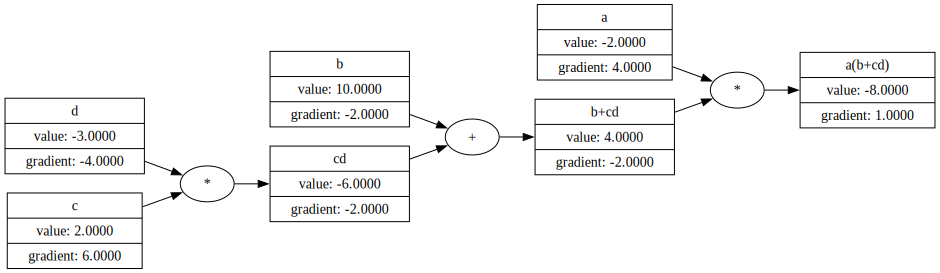

In [4]:
a = Value(-2.0, label="a");
b = Value(10.0, label="b");
c = Value(2.0, label="c");
d = Value(-3.0, label="d");
e = c*d; e.label = "cd";
f = b+e; f.label = "b+cd";
L = a*f; L.label = "a(b+cd)";
L.backpropagation()
L.render_graph()